# Урок 1. Метод K-Nearest Neighbors (K ближайших соседей).

Начнем разбор алгоритмов машинного обучения с наиболее прозрачной для понимания задачи классификации. Чтобы понять, что это за задача и для чего она вообще решается, давайте вспомним о весьма перспективной разработке - беспилотных автомобилях. Понятно, что сама по себе машина не понимает, что такое проезжая часть, и не может отличить человека от светофора - для этого ее надо научить различать знаки, людей, животных и т.д. Здесь, помимо достаточно сложных отраслей машинного обучения, таких как машинное зрение и системы принятия решений, используется классификация: автомобиль "учится" различать препятствия, которые необходимо объехать; людей, чтобы пропустить их при переходе дороги; знаки, чтобы точно следовать правилам. Говоря простым языком, система относит объекты к тому или иному классу, чтобы правильно себя вести при встрече с ними, то есть классификация в машинном обучении - не что иное, как задача отнесения объекта к одному из заранее определенных классов на основании его признаков.

Начнем с kNN - одного из наиболее распространенных методов классификации в ML. Его достаточно просто реализовать в отличие от других алгоритмов, поэтому для наглядности того, как в целом работает классификация, мы сначала напишем собственную реализацию и посмотрим на результаты, применив метод к стандартному датасету Iris, а затем сравним с библиотечной реализацией из библиотеки *sklearn*. Следующие алгоритмы мы не будем разбирать настолько досконально из-за трудоемкой реализации - рассмотрим общую методологию и разберем, на основе чего алгоритм принял решение в пользу того или иного класса.

Метод kNN относится к разряду ленивых классификаторов. В целом это указывает на то, что метод "обучается" лишь  на новых данных, не учитывая предыдущий опыт. В данном же случае это означает, что в процессе обучения алгоритм не делает ничего, а только сохраняет размеченные тренировочные данные. Сам процесс классификации начинается только тогда, когда появляются новые немаркированные данные - алгоритм по каким-то признакам считает расстояния между уже размеченными и еще неизвестными объектами в пространстве. Очевидно, что, если мы будем рассчитывать расстояния между известными данными и каждым новым набором неразмеченных данных, то каждый раз будем получать различные расстояния между объектами, поэтому изначально "обучать" алгоритм на одних расстояниях, чтобы он запомнил, на какой позиции к какому классу относится объект, совершенно не имеет смысла - позиций может быть бесконечное множество, поэтому хранить их все в памяти не получится.

Еще один важный момент: как понять, насколько точно модель строит прогнозы? В данном случае одним из простейших способов определить ошибку является просто вычисление отношения числа верных предсказаний к общему количеству сделанных предсказаний. Эту метрику называют *долей правильных ответов*. Очевидно, ее значения будут находиться в пределах от 0 до 1, где 0 - совершенно бесполезная модель, а 1 - абсолютно точная.

Алгоритм kNN состоит из трех последовательных этапов:
- вычислить расстояние от целевого объекта (который необходимо классифицировать) до каждого из объектов обучающей выборки (уже маркированных каким-либо классом);

![](https://248006.selcdn.ru/public/DS_Block2_M5_final/knn-1.png)

- отобрать $k$ объектов обучающей выборки, расстояния до которых минимальны (на первом этапе $k$ выбирается произвольно, затем итеративно подбирается лучшее значение $k$ на основе точности полученных прогнозов при каждом из выбранных $k$);

![](https://248006.selcdn.ru/public/DS_Block2_M5_final/knn-2.png)

- получить класс объекта на основе наиболее часто встречающегося среди $k$ ближайших соседей (это может быть число или название класса в зависимости от того, как изначально были обозначены классы - например, в примере с беспилотниками это может быть "человек" или "бетонный блок").

![](https://248006.selcdn.ru/public/DS_Block2_M5_final/knn-3.png)

Здесь стоит отметить, что количество классов модель выясняет сама уже в процессе классификации: информация о классе содержится в самих объектах размеченных данных (во всех соседях), поэтому просто посчитать количество экземпляров одного и того же класса для алгоритма не составляет труда.

Импорт набора данных Iris.
Он представляет собой собрание морфологических измерений нескольких сортов ирисов и для каждого растения имеет 4 характеристики:
- длина чашелистика
- ширина чашелистика
- длина лепестка
- ширина лепестка

In [1]:
from sklearn.datasets import load_iris
iris_dataset = load_iris() # возвращает объект с несколькими полями

Посмотрим, что включает в себя набор данных.

In [2]:
iris_dataset.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [4]:
print(iris_dataset['DESCR'][:177]) # описание датасета

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes


In [5]:
iris_dataset['target_names'] # виды ирисов

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [6]:
iris_dataset['feature_names'] # характеристики каждого цветка

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [7]:
print(iris_dataset['target'].shape) # каждый цветок соответствует виду
iris_dataset['target'] # 0 - setosa, 1 - versicolor, 2 - virginica

(150,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [8]:
print(type(iris_dataset['data'])) 
iris_dataset['data'].shape # всего 150 цветков, у каждого 4 измерения

<class 'numpy.ndarray'>


(150, 4)

Теперь взглянем на наши данные.

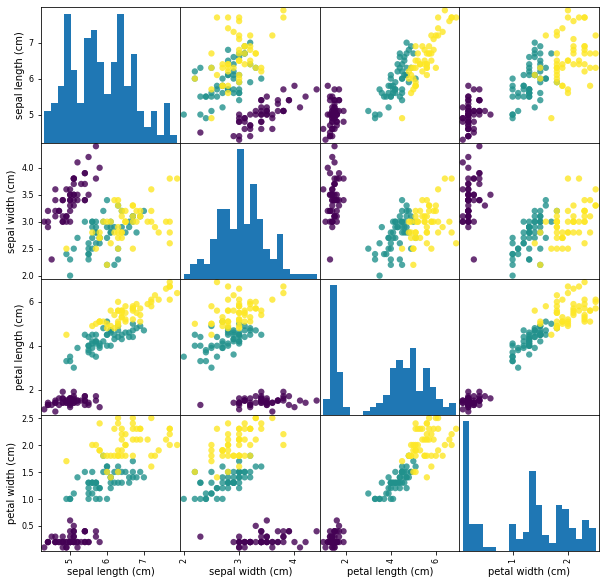

In [9]:
import pandas as pd

iris_dataframe = pd.DataFrame(iris_dataset['data'], columns=iris_dataset.feature_names)
scat_mtrx = pd.plotting.scatter_matrix(iris_dataframe, c=iris_dataset['target'], figsize=(10, 10), marker='o',
                                       hist_kwds={'bins': 20}, s=40, alpha=.8)

Из графиков мы можем заметить, что данные классов, по-видимому, хорошо сепарируются (от __separate__ - разделять) по измерениям лепестков и чашелистиков, поэтому, скорее всего, модель машинного обучения сможет научиться неплохо их разделять.

Но при четырех параметрах достаточно сложно представить, как расположены объекты относительно друг друга, так как придется работать в четырехмерном пространстве. По графикам видно, что лучше всего цветки разбиваются по измерениям длины и ширины лепестка (petal length, petal width), поэтому для наглядности оставим только эти данные.

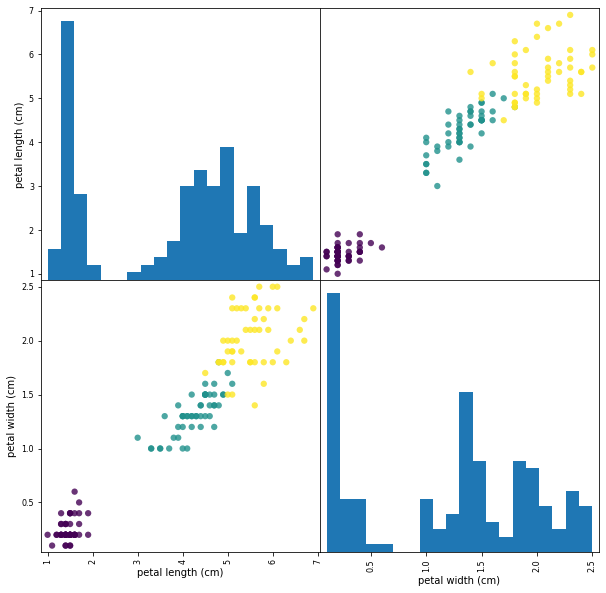

In [10]:
iris_dataframe_simple = pd.DataFrame(iris_dataset.data[:, 2:4], columns=iris_dataset.feature_names[2:4])
scat_mtrx = pd.plotting.scatter_matrix(iris_dataframe_simple, c=iris_dataset['target'], figsize=(10, 10), marker='o',
                                       hist_kwds={'bins': 20}, s=40, alpha=.8)

Разобьем данные на тренировочный и тестовый датасеты и для простоты реализации алгоритма объединим массивы признаков объектов и метки их классов, чтобы было понятно, к какому классу относится каждый объект.

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(iris_dataset.data[:, 2:4], 
                                                    iris_dataset['target'],
                                                    random_state=0) # random_state - для воспроизводимости

print(f'X_train shape: {x_train.shape}, y_train shape: {y_train.shape},\n'
      f'X_test shape: {x_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (112, 2), y_train shape: (112,),
X_test shape: (38, 2), y_test shape: (38,)


In [12]:
import numpy as np

x_train_concat = np.concatenate((x_train, y_train.reshape(112, 1)), axis=1)
x_test_concat = np.concatenate((x_test, y_test.reshape(38, 1)), axis=1)
print(f'X_train shape: {x_train_concat.shape},\n'
      f'X_test shape: {x_test_concat.shape}')

X_train shape: (112, 3),
X_test shape: (38, 3)


In [14]:
pd.DataFrame(x_train_concat).head(5)

,0,1,2
0,4.2,1.5,1.0
1,4.0,1.2,1.0
2,5.5,2.1,2.0
3,1.3,0.2,0.0
4,5.1,2.3,2.0


Как мы видим, теперь в последнем столбце у нас присутствуют метки класса.

Приступим к реализации алгоритма.

Для начала определим метрику, по которой будем определять расстояние между объектами. Обозначим через $x = (x_1, x_2, \ldots, x_n)$ координаты объекта $x$ в n-мерном пространстве, а через $y = (y_1, y_2, \ldots, y_n)$ - координаты объекта $y$. 

По умолчанию алгоритм использует метрику Минковского, которая в случае степени p = 2 обращается во всем известную из школьной геометрии Евклидову метрику - расстояние между двумя точками в пространстве:
$$
dist = \sqrt{(x_1-y_1)^2 + (x_2 - y_2)^2 + \ldots + (x_n - y_n)^2}
$$
Ее и будем использовать.

In [15]:
import math

def euclidean_distance(data1, data2):
    distance = 0
    for i in range (len(data1) - 1):
        distance += (data1[i] - data2[i]) ** 2
    return math.sqrt(distance)

Вычислим расстояния до всех точек обучающей выборки и отберем $k$ соседей (то есть тех, расстояния до которых минимальны).

In [16]:
def get_neighbors(train, test, k=1):
    distances = [(train[i][-1], euclidean_distance(train[i], test))
                  for i in range (len(train))]
    distances.sort(key=lambda elem: elem[1])
    
    neighbors = [distances[i][0] for i in range (k)]
    return neighbors

Теперь получим прогноз на основе классов соседей. Посчитаем, сколько объектов каждого класса присутствует среди $k$ ближайших к целевому, и затем причислим его к тому классу, экземпляров которого больше всего.

In [ ]:
def prediction(neighbors):
    count = {}
    for instance in neighbors:
        if instance in count:
            count[instance] +=1
        else :
            count[instance] = 1
    target = max(count.items(), key=lambda x: x[1])[0]
    return target

Напишем последнюю функцию для оценки точности прогнозов. О ней речь шла в самом начале - это просто отношение верных прогнозов к общему количеству прогнозов.

In [ ]:
def accuracy(test, test_prediction):
    correct = 0
    for i in range (len(test)):
        if test[i][-1] == test_prediction[i]:
            correct += 1
    return (correct / len(test))

Посмотрим, как работает наш алгоритм.

In [ ]:
predictions = []
for x in range (len(x_test_concat)):
    neighbors = get_neighbors(x_train_concat, x_test_concat[x], k=5)
    result = prediction(neighbors)
    predictions.append(result)
#     print(f'predicted = {result}, actual = {x_test_concat[x][-1]}') # если есть интерес посмотреть, какие конкретно прогнозы некорректны
accuracy = accuracy(x_test_concat, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9736842105263158


Теперь импортируем библиотечную версию алгоритма.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

Объект *knn* инкапсулирует алгоритм, который будет использоваться для построения модели из обучающих данных, а также для прогнозирования новых точек данных. Он также будет содержать информацию, которую алгоритм извлек из обучающих данных. В случае *KNeighborsClassifier* он будет просто хранить учебный набор. 

Для построения модели на обучающем множестве вызывается метод *fit* объекта *knn*, который принимает в качестве аргументов массив NumPy *x_train*, содержащий обучающие данные, и массив NumPy *y_train* соответствующих обучающих меток.

In [ ]:
knn_model = knn.fit(x_train, y_train)

Для предсказаний вызывается метод *predict*, который в качестве аргументов принимает тестовые данные.

In [ ]:
knn_predictions = knn.predict(x_test)
knn_predictions

array([2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1,
       0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 2])

Для проверки импортируем простую встроенную метрику *accuracy_score*, которая определяет долю правильных ответов.

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, knn_predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9736842105263158


Как мы видим, реализованный вручную алгоритм при данных параметрах по точности сопоставим с библиотечной моделью, однако на практике стоит пользоваться именно готовыми реализациями, так как зачастую они гораздо лучше оптимизированы и быстрее/лучше работают с большими выборками данных.

# Урок 2. Наивный байесовский классификатор.

Наивный байесовский классификатор - семейство алгоритмов классификации, которые принимают допущение о том, что каждый параметр классифицируемых данных не зависит от других параметров объектов, т.е. ни один из параметров не оказывает влияние на другой.
Согласитесь, что достаточно наивно было бы предполагать, что, допустим, рост и вес человека - совершенно независимые параметры.

Для начала посмотрим на примере, как работает этот алгоритм.
Допустим, у нас имеется небольшой набор данных Fruits, в котором представлена информация о видах {banana, orange, plum}. Отметим, что это просто конкретные имеющиеся "измерения", на которых обучается модель, и мы хотим научиться определять по этим данным, какой фрукт перед нами.

В последнем столбце $Total$ представлено количество фруктов определенного класса (500 бананов, 300 апельсинов и 200 слив - всего 1000). В строке же $Total$ - общее количество фруктов с определенными признаками {long, sweet, yellow}. 

In [7]:
import numpy as np
import pandas as pd

data = np.array([[400, 350, 450, 500],
                 [0, 150, 300, 300],
                 [30, 180, 100, 200],
                 [430, 680, 850, 1000]])
idx = ['Banana', 'Orange', 'Plum', 'Total']
col = ['Long', 'Sweet', 'Yellow', 'Total']

fruits = pd.DataFrame(data, columns=col, index=idx)
fruits

,Long,Sweet,Yellow,Total
Banana,400,350,450,500
Orange,0,150,300,300
Plum,30,180,100,200
Total,430,680,850,1000


Здесь для простоты мы оперируем интуитивно понятными бинарными признаками, т.е. фактически любой из признаков мы можем определить как "да" или "нет". В соответствии с этим, например, получается, что среди бананов 400 из 500 длинные, 350 - сладкие, а 450 - желтые. Соответственно, если у нас "на руках" именно эти данные, то можно сказать, что, если у нас в руках банан, то он с вероятностью 80% длинный (вероятность считаем как отношение объектов с данным признаком к общему числу объектов -в данном случае 400/500 = 0,8), с вероятностью 70% (350/500 = 0,7) - сладкий, и с вероятностью 90% (450/500 = 0,9) - желтый.

В случае с дискретными признаками (которые принимают значения исключительно из определенного набора значений) всегда составляется подобная частотная таблица для каждого класса и каждого признака, указывающая, сколько раз значение определенного признака встречается в каждом классе.

Теперь, если мы получим только параметры - длину, сладость и цвет фрукта, сможем вычислить вероятность того, что фрукт является бананом, апельсином или сливой. Допустим, мы хотим узнать, к какому классу относится фрукт с параметрами {длинный, сладкий, желтый}. Вероятность того, что объект принадлежит какому-либо классу при данных параметрах обозначается как: 

$$
P(Class|Long, Sweet, Yellow)
$$

Чтобы вычислить вероятность в случае дискретных (конечных) данных, мы делим количество соответствующих признаку объектов на общее число объектов. Например, если мы хотим узнать вероятность $P(Long|Banana)$, мы вычисляем $400 / 500 = 08$, как уже упоминалось выше.

Данный метод основан на теореме английского математика-статистика Томаса Байеса. По сути, она позволяет предсказать класс на основании набора параметров, используя вероятность. Общая формула Байеса для класса с одним признаком выглядит так:

$$
P(Class A|Feature 1) = \frac{P(Feature 1|Class A)\cdot P(Class A)}{P(Feature 1)}
$$

$P(Class A|Feature 1)$ - вероятность того, что объект является классом $A$ при том, что его признак соответствует $Feature 1$.

Упрощенное уравнение для классификации при двух признаках выглядит так:

$$
P(Class A|Feature 1, Feature 2) = \frac{P(Feature 1|Class A)\cdot P(Feature 2|Class A)\cdot P(Class A)}{P(Feature 1)\cdot P(Feature 2)}
$$

И далее для большего количества признаков формула меняется соответствующим образом.

Напомним, что вероятность - число, которое принимает значения от 0 до 1, при этом 0 - полное несоответствие класса признакам, а 1 - однозначно определенный класс. Соответственно, чем ближе значение вероятности определенного класса к 1, тем больше шанс того, что объект принадлежит именно этому классу.

Знаменатель можно проигнорировать, так как он будет одинаков для всех вычислений и никакой важной информации не даст.
Тогда получится следующее уравнение:

$$
P(Class A|Feature 1, Feature 2) = P(Feature 1|Class A)\cdot P(Feature 2|Class A)\cdot P(Class A)
$$

То есть для каждого возможного класса вычисляем только произведение вероятностей того, что каждый признак соответствует классу, и вероятности того, что объект принадлежит этому классу. Соответственно, наибольшее значение этого произведения, рассчитанного с признаками конкретного объекта, для какого-то из классов будет указывать на принадлежность объекта к этому классу.

Вернемся к нашему примеру с фруктами. Чтобы понять, к какому классу принадлежит объект с признаками {Long, Sweet, Yellow}, рассчитаем для каждого из классов формулу Байеса, используя для этого данные частотной таблицы. На выходе получаем вероятность того, что объект принадлежит классу. Класс с наибольшей вероятностью является ответом.

In [8]:
result = {}
for i in range (fruits.values.shape[0] - 1):
    p = 1
    for j in range (fruits.values.shape[1] - 1):
        p *= fruits.values[i, j] / fruits.values[i, -1]
    p *= fruits.values[i, -1] / fruits.values[-1, -1]
    result[fruits.index[i]] = p
    
result

{'Banana': 0.252, 'Orange': 0.0, 'Plum': 0.013500000000000002}

Как мы видим, фрукт с параметрами {long, sweet, yellow} с наибольшей вероятностью принадлежит классу "Banana", что, кажется, соответствует реальности.

Но что делать, если у нас не частотная таблица, как в примере выше, а непрерывные данные? Например, мы не можем вычислять, сколько человек с конкретным ростом 1,81м, 1,67м и т.д. присутствует в выборке - нам это попросту ничего не даст, а лишь добавит громоздких вычислений. Поэтому обычно при непрерывных значениях параметров используется гауссовский наивный Байес, в котором сделано предположение о том, что значения параметров взяты из нормального распределения.

![](https://248006.selcdn.ru/public/DS_Block2_M5_final/GNB.gif)

На графике - плотность вероятности нормального распределения. По сути, где больше площадь под графиком, там и наиболее вероятные значения. Поскольку способ представления значений в наборе данных изменяется, то и формула условной вероятности изменяется на 

$$
p(x_i|y) = \frac{1}{\sqrt{2\pi \sigma^2_y}}exp(-\frac{(x_i - \mu_y)^2}{2\sigma^2_y})
$$

Здесь $\sigma^2$ - дисперсия (разброс) данных, а $\mu$ - математическое ожидание (среднее значение). При этом $y$ - предполагаемый класс, а $x_i$ - значение признака у того объекта, который нужно классифицировать.

По большому счету в нашей начальной формуле для вычисления вероятности того, что объект с данными признаками относится к конкретному классу, мы просто заменяем формулу вычисления вероятности как отношения количества соответствующих признаку объектов к общему числу объектов на данную, а дальше проводим идентичные вычисления.

Помимо гауссовского существуют еще два типа моделей на основе наивного байесовского классификатора: полиномиальная и с распределением Бернулли. *Полиномиальная* в основном используется для задачи классификации документов, т.е. определяет, к каким категориям относится текст: спорт, политика, техника и т.д. Используемые признаки являются частотой слов, присутствующих в документе. *Классификатор на основе распределения Бернулли* похож на полиномиальный метод, но признаками являются булевы переменные, т.е. они принимают только значения "yes" и "no" - например, встречается слово в тексте или нет. Используется в основном для классификации небольших текстов.

Теперь импортируем модель GaussianNB из библиотеки sklearn и посмотрим, как она работает на уже известном нам датасете Iris.

In [9]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

In [12]:
from sklearn.datasets import load_iris
iris_dataset = load_iris() # возвращает объект с несколькими полями

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(iris_dataset.data[:, 2:4], 
                                                    iris_dataset['target'],
                                                    random_state=0) # random_state - для воспроизводимости

In [13]:
nb_model = nb.fit(x_train, y_train)

Получим предсказания для тестовых данных.

In [14]:
nb_predictions = nb.predict(x_test)
nb_predictions

array([2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1,
       0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 2])

Для определения точности предсказаний воспользуемся встроенной функцией *score*.

In [15]:
accuracy = nb.score(x_test, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9736842105263158


Вспомним результаты метода kNN.

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5).fit(x_train, y_train)
knn_predictions = knn.predict(x_test)

accuracy = accuracy_score(y_test, knn_predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9736842105263158


Как видно, на одних и тех же данных алгоритм GaussianNB работает так же, как и kNN. Вполне возможно, что при корректировке количества соседей в kNN метод будет работать точнее, но при равных условиях подбор оптимальных гиперпараметров займет явно больше времени, чем использование алгоритма "из коробки".

Несмотря на простоту, наивный байесовский алгоритм может быть удивительно точным. В целом, наивные байесовские алгоритмы используются в анализе настроений, фильтрации спама, системах рекомендаций и т.д. Они быстры и просты в реализации, но их основным недостатком является требование к признакам быть независимыми. В большинстве реальных датасетов они являются зависимыми, а это в свою очередь снижает производительность классификатора.

# Урок 3. Деревья решений.

Деревья решений - один из наиболее популярных методов классификации. Одной из причин их популярности является то, что окончательную модель крайне легко понять - достаточно построить граф решений и посмотреть, почему был сделан тот или иной прогноз.
$$ $$
Также деревья решений являются основой таких методов как бэггинг, случайные леса и градиентный бустинг, о которых будем говорить позднее.

Например, деревья решений часто используются в банковском скоринге (системе оценки клиентов). Наглядно решение о выдаче кредита заемщику можно представить в таком виде:

![](https://248006.selcdn.ru/public/DS_Block2_M5_final/DT.gif)

По сути, деревьями принятия решений решается задача бинарной классификации (здесь листы решающего дерева могут иметь только два значения: "Выдать кредит" и "Отказать"). Как видно по графу, огромное преимущество деревьев состоит в том, что они легко интерпретируемы: например, в этом примере по схеме можно объяснить, почему было принято решение об отказе в кредите.

Перейдем к алгоритму деревьев решений, реализованному в библиотеке *sklearn* - CART. Его можно использовать как для задач классификации, так и для задач регрессии. Мы сосредоточимся на задаче классификации.

Модель CART представляет собой двоичное дерево - каждый узел может иметь нуль, один или два дочерних узла.

Узел представляет собой точку разделения входных данных, а конечный (терминальный) узел - выходную переменную, которая будет использоваться для прогнозирования.

Посмотрим, как строится такое дерево на упрощенном примере, показывающем выживаемость пассажиров корабля Титаник на основе возраста (age), пола (sex) и наличия супруга и братьев и сестер (sibsp)  на борту.

![](https://248006.selcdn.ru/public/DS_Block2_M5_final/CART_titanic.png)

Десятичные числа под листьями показывают вероятность выживания, а целые - процент наблюдений (от общего количества пассажиров) в листе.

Если со структурой дерева все понятно, то как понять, каким образом лучше разделить выборку данных? Ведь у нас не всегда бинарные признаки  типа "имеется дом" или "не имеется" - в этом наборе данных, например, есть непрерывная переменная "возраст". В этом случае помогут определенные критерии качества разбиения. Обычно в задаче классификации используются энтропия или неопределенность Джини.

По своей сути *энтропия* - это степень хаоса в системе: чем больше различных элементов в множестве, тем выше его энтропия.
В целом, алгоритм подбирает такое разбиение, чтобы минимизировать энтропию, т.е. уменьшить количество объектов разных классов в листе.

Подробнее об энтропии в деревьях принятия решений и представленном примере [здесь](https://habr.com/ru/post/171759/)

Неопределенность Джини можно интерпретировать как вероятность неправильной классификации, если предсказывать классы с вероятностями их появления в этом узле. Соответственно, чем меньше неопределенность Джини, тем более точно работает модель.

На деле минимизация энтропии и неопределенность Джини работают почти одинаково - график энтропии очень близок к графику удвоенной неопределенности Джини, поэтому разница в их использовании будет минимальна.

Теперь вернемся к нашему примеру. Для начала по какому-то заранее определенному критерию (например, энтропии) алгоритм выбирает *начальную точку разбиения входных данных*, рассчитав этот критерий для каждого признака - получает разделение по половому признаку, что очевидно, т.к. разделение по бинарному признаку в самом начале (определение пола) даст больше информации, чем перебор всех возрастов. Переходим к 3-му пункту алгоритма построения дерева - рекурсивному повторению вычислений для каждого получившегося листа.

Далее для одного листа заканчиваем вычисления (возможно, это конечный узел - мы получили нужную вероятность, поэтому дальше вычисления не имеют смысла), а для второго листа вычисляем критерий качества либо для всех возрастов, либо разделяем их на определенные промежутки (например, считаем энтропию через каждые два года, начиная с самого раннего возраста, что упрощает вычисления). Получаем, что лучшее разбиение по критерию качества дает нам *точку разделения данных* для следующего листа 9,5 лет. Далее рекурсивно продолжаем вычисления, пока не получим необходимую информацию.

Подводя итог: шансы на выживание у пассажира были бы больше, если бы он был либо женщиной, либо маленьким мальчиков без большого количества родственников на борту.

В общем виде алгоритм построения дерева можно описать следующим образом:
- вычисляем выбранный критерий качества разбиения для всех элементов исходного множества
- выбираем такое разбиение, при котором критерий качества является наилучшим
- рекурсивно повторяем процедуру для каждого получившегося подмножества

Критерием останова может служить как *энтропия или неопределенность Джини == 0*, так и заранее выбранная максимальная глубина дерева, максимальное количество листов дерева и т.д.

Модель предоставляет возможность варьировать различные гиперпараметры алгоритма, такие как критерий разбиения, максимальная глубина дерева, стратегия разбиения на поддеревья, минимальное количество объектов в листе и т.д. 

Когда мы строим деревья решений, существует большой риск переобучения, так как дерево можно разбить на сколько угодно поддеревьев, которые способны разделять обучающий набор данных вплоть до листов, в которых будет всего один элемент - для предсказаний такие деревья почти бесполезны, так как они слишком точно описывают один тестовый набор данных, в то время как другие данные, которые необходимо классифицировать, могут сильно от него отличаться. В целом, не существует одного правила, которое бы описывало построение любого дерева - в каждом случае критерий останова подбирается индивидуально. Однако можно предложить несколько эвристических правил:
- заранее определенная максимальная глубина дерева (количество узлов одного уровня в дереве - по сути, количество ветвей от первого узла до листа) чревата тем, что будут пропущены важные, но труднообнаруживаемые разбиения, поэтому лучше использовать последующую обрезку дерева, когда сначала строится все дерево решений, а потом по определенным правилам производится его обрезка (например, отсекаются те узлы и ветви, использование которых мало влияет на качество классификации - не сильно уменьшает ошибки);
- разбиение должно быть нетривиальным, т.е. полученные в результате узлы должны сорержать не менее заданного количества объектов - как мы уже отметили,  переобученная на тренировочных данных модель не имеет практической пользы для классификации новых данных;
- если даже усеченные (после обрезки) деревья все еще сложны для восприятия, можно прибегнуть к методике извлечения правил (условий в узлах) из дерева с последующим созданием наборов правил в одном узле.

Мы же ограничимся тем, что построим две модели с критериями качества разбиения, которые рассматривали выше.

По умолчанию алгоритм использует неопределенность Джини.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

In [ ]:
dtc_model = dtc.fit(x_train, y_train)

Визуализируем граф обученной модели. Для этого понадобится установить библиотеку *graphviz*.

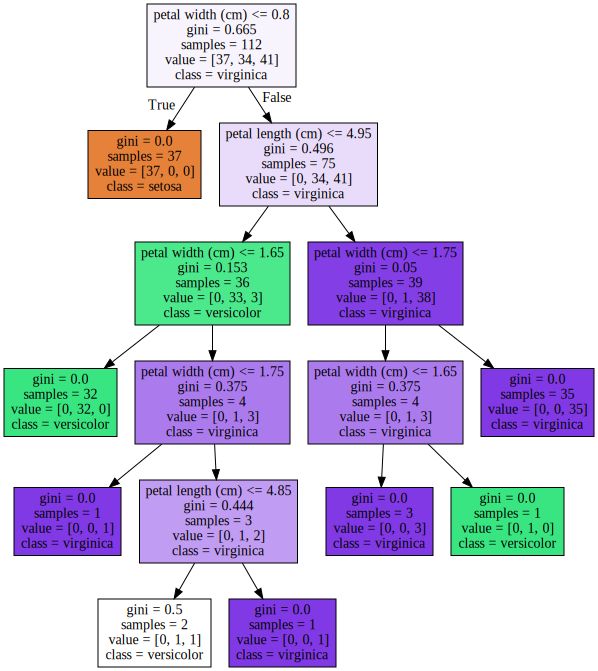

In [ ]:
from sklearn import tree
import graphviz

def print_graph(data):
    dot_data = tree.export_graphviz(data, out_file=None,
                                    feature_names=iris_dataset.feature_names[2:4],  
                                    class_names=iris_dataset.target_names,  
                                    filled=True)  
    return graphviz.Source(dot_data)  

print_graph(dtc_model)

Такое дерево читается по цветам: чем больше в узле объектов одного класса, тем насыщеннее будет его цвет: как мы видим, при соотношении объектов внутри узла (50:50), цвет узла является чисто белым, а при преобладании объектов какого-либо из классов, он становится ближе к цвету того класса, объектов которого в узле больше. В данном случае почти во всех узлах преобладают цветки класса "virginica".

Но вообще, больше информации мы можем получить, посмотрев на условия разбиения в каждом узле (условия вида x < a).

Получим предсказания для тестовых данных.

In [ ]:
dtc_predictions = dtc.predict(x_test)

Для определения точности предсказаний воспользуемся встроенной функцией score.

In [ ]:
accuracy = dtc.score(x_test, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9473684210526315


Теперь построим и обучим модель с критерием качества разбиения *энтропия*.

In [ ]:
dtc_entrp = DecisionTreeClassifier(criterion='entropy')
dtc_model_entrp = dtc_entrp.fit(x_train, y_train)
dtc_predictions_entrp = dtc_entrp.predict(x_test)
accuracy = dtc_entrp.score(x_test, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9473684210526315


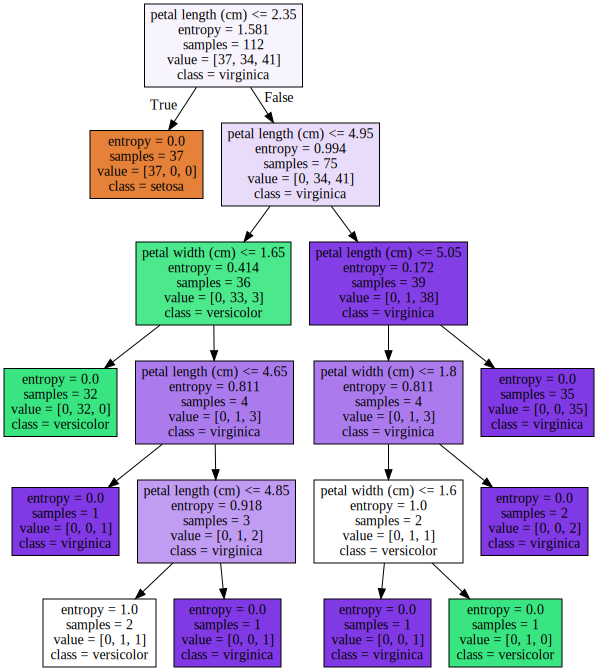

In [ ]:
print_graph(dtc_model_entrp)

Как мы можем видеть, при таких параметрах алгоритм работает менее точно, чем kNN и наивный Байес. Можно предположить, что алгоритму не хватает двух признаков для качественного разбиения на поддеревья - на большем количестве данных по каждому объекту метод скорее всего будет работать более точно.

Определенно, деревья решений имеют ряд плюсов: они легко интерпретируемы, визуализируемы (исчезает эффект "черного ящика"), достаточно быстро обучаются и делают прогнозы, имеют небольшое количество параметров модели и поддерживают как категориальные, так и числовые признаки. 

Однако при этом они очень чувствительны к шумам во входных данных, подвержены переобучению - для борьбы с ним необходимо корректно устанавливать гиперпараметры (максимальную глубину дерева или минимальное число элементов в листьях деревьев), а также не умеют предсказывать данные, выходящие за рамки обучающего датасета

В целом, несмотря на то, что алгоритм достаточно прост для понимания и реализации, он нашел широкое применение в таких областях как рекомендательные системы, семантический поиск и обнаружение аномалий. Однако для его применения мы должны быть в состоянии сохранить весь обучающий набор в памяти, а выполнение классификаций может быть вычислительно дорогостоящим, поскольку алгоритм анализирует все точки данных для каждой классификации. По этим причинам kNN лучше всего применять к небольшим наборам данных, которые не имеют огромного набора признаков.